In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

# 读取数据

In [2]:
x_data = pd.read_excel("Shenyan_S82_ESPdescriptor+汪老师提取的所有特征-不含FE.xlsx")
x_data

c1nc[nH]n1  c1c[nH]cn1  c1cc[nH]c1  c1ccncc1  c1ccc2[nH]ccc2c1  \
0            0           0           0         0                 0   
1            0           0           0         0                 0   
2            0           0           0         0                 0   
3            0           0           0         0                 0   
4            0           0           0         0                 0   
..         ...         ...         ...       ...               ...   
77           0           0           0         0                 0   
78           0           0           0         0                 0   
79           0           0           0         0                 0   
80           0           0           0         0                 0   
81           0           0           0         0                 0   

    c1ccc2scnc2c1  c1ccc2cc3ccccc3cc2c1  c1cscn1  c1ccsc1  c1cn[nH]c1  \
0               0                     0        0        1           0   
1               0                     0        0        1           0   
2               0                     0        0        0           0   
3               0                     0        0        0           0   
4               0                     0        0        0           0   
..            ...                   ...      ...      ...         ...   
77              0                     0        0        0           0   
78              0                     0        0        0           0   
79              0                     0        0        0           0   
80              0                     0        0        0           0   
81              0                     0        0        0           0   

    c1ccc2occcc2c1  c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2  c1ccccc1  \
0                0                                     0         0   
1                0                                     0         0   
2                0                                     0         0   
3                0                                     0         0   
4                0                                     0         0   
..             ...                                   ...       ...   
77               0                                     0         0   
78               0                                     0         0   
79               0                                     0         0   
80               0                                     0         0   
81               0                                     0         0   

    c1nnn[nH]1  c1ccc2sc[n+]c2c1  c1ccc2ncccc2c1  c1nncs1  Alkene  \
0            0                 0               0        0       0   
1            0                 0               0        0       0   
2            0                 0               0        0       0   
3            0                 0               0        0       0   
4            0                 0               0        0       2   
..         ...               ...             ...      ...     ...   
77           0                 0               0        0       0   
78           0                 0               0        0       0   
79           0                 0               0        0       0   
80           0                 0               0        0       0   
81           0                 0               0        0       0   

    Alkylchloride  Alkylfluoride  Alkylbromide  Trifluoromethyl  Alcohol  \
0               0              0             0                0        0   
1               0              0             0                0        0   
2               0              0             0                0        0   
3               0              0             0                0        0   
4               0              0             0                0        0   
..            ...            ...           ...              ...      ...   
77              0              0             0                0        0   
78      

In [3]:
y_data = pd.read_csv("Target.csv", usecols=[7])
y_data

FE n-PrOH
0    0.000000
1    0.000000
2    1.501805
3    0.000000
4    0.000000
..        ...
77   0.000000
78   0.581841
79   0.000000
80   0.000000
81   1.607906

[82 rows x 1 columns]

In [4]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [5]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  # 通过训练集获得归一化函数模型，使用 x_train 数据来计算缩放器需要的最小值和最大值
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)#使用拟合好的缩放器对 x_train 数据进行缩放
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [6]:
num_cores = multiprocessing.cpu_count()

In [7]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) # 5折交叉验证
#mse它测量的是预测值与实际值之间差值的平方的平均值。均方误差越小，模型的预测性能越好
variate=list(range(x_train.shape[1]))   #变量索引列表
selected=[]   #变量索引
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  
#验证集目前的分数和最好分数初始值都为无穷大（因为mse越小越好）
    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

#循环筛选变量
while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  #逐个遍历自变量
        current_variate = selected+[i]   #当前变量
        current_x_train = x_train[:, current_variate]   #当前x_train
        current_x_test = x_test[:, current_variate]   #当前x_test
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
    selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])
        
        #if current_score>best_new_score:
            #variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            #selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
            #current_score = best_new_score  #最新的分数等于最好的分数
            #print("score is {},continuing!".format(current_score))  #输出最小的mse值
        #else:
            #print("for selection over!")
            #break

In [21]:
selected

[106,
 196,
 306,
 30,
 257,
 140,
 112,
 187,
 303,
 14,
 305,
 24,
 178,
 3,
 68,
 32,
 249,
 115,
 176,
 7,
 101,
 54,
 0,
 145,
 1,
 180,
 2,
 4,
 183,
 6,
 275,
 273,
 241,
 48,
 102,
 9,
 11,
 13,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 110,
 250,
 49,
 119,
 19,
 21,
 46,
 28,
 69,
 27,
 217,
 156,
 75,
 216,
 58,
 118,
 130,
 143,
 51,
 50,
 57,
 17,
 153,
 139,
 146,
 92,
 304,
 167,
 91,
 134,
 262,
 98,
 59,
 258,
 271,
 164,
 281,
 38,
 227,
 263,
 259,
 135,
 181,
 126,
 254,
 52,
 148,
 218,
 295,
 190,
 138,
 67,
 299,
 163,
 99,
 240,
 296,
 108,
 124,
 125,
 107,
 233,
 270,
 122,
 219,
 261,
 297,
 268,
 246,
 198,
 123,
 166,
 161,
 96,
 144,
 162,
 66,
 226,
 81,
 87,
 31,
 169,
 76,
 234,
 80,
 103,
 127,
 224,
 298,
 272,
 82,
 22,
 23,
 279,
 237,
 188,
 84,
 221,
 236,
 232,
 244,
 113,
 276,
 170,
 252,
 149,
 255,
 12,
 300,
 277,
 184,
 302,
 278,
 253,
 235,
 93,
 45,
 151,
 301,
 157,
 282,
 79,
 150,
 129,

In [15]:
train_mse_list

[0.046277656751833554,
 0.0401190728201838,
 0.03780835662144086,
 0.025664531846366283,
 0.0254475218550745,
 0.024608951438459446,
 0.024098265614005764,
 0.02429693188558647,
 0.024534759472214535,
 0.025534668308806165,
 0.025780324724389708,
 0.026698259228436688,
 0.02524741717651092,
 0.024603136283204062,
 0.02371370542899643,
 0.024422708633887763,
 0.024975438449796918,
 0.025098078366678905,
 0.02503147680336551,
 0.020723848064065083,
 0.019441505899590723,
 0.020007919970492335,
 0.02030575329682276,
 0.02041973592312487,
 0.020685751841468418,
 0.02090066801625453,
 0.021096387596938874,
 0.021259983130495912,
 0.021392037786368664,
 0.021518169040533823,
 0.02115032841607631,
 0.020109237274809063,
 0.020324074666485836,
 0.02059300023152382,
 0.020682029274905256,
 0.020783436407694672,
 0.020873580458824835,
 0.020953799246535343,
 0.021032101797200685,
 0.021109619117745927,
 0.02117869191772786,
 0.021242714705390086,
 0.021306368135838468,
 0.021360495331562167,
 0.

In [16]:
val_mse_list

[0.05714201631498287,
 0.0556571412352323,
 0.05703356416350354,
 0.04154383218908771,
 0.03885622391773445,
 0.037366640623238974,
 0.03718084218193081,
 0.03748344769481401,
 0.037769937872812846,
 0.03939875639744341,
 0.04148291080762912,
 0.043260669831689115,
 0.043575232392992845,
 0.04326118242685719,
 0.042407875858551,
 0.041709562335708085,
 0.04157966788656315,
 0.04149920756412776,
 0.04149407047398885,
 0.04147040824520381,
 0.04137189853341079,
 0.04094788435176261,
 0.04095990117522049,
 0.04097539614588302,
 0.0410085516661569,
 0.04104893185294549,
 0.041101882514520474,
 0.04113658579367057,
 0.041158285121544506,
 0.041243093861019035,
 0.041273930331973345,
 0.040899372575965154,
 0.04072535591441668,
 0.04053939805897813,
 0.040562392901508294,
 0.04058718792868937,
 0.040594082642128076,
 0.04062599527378833,
 0.04065212634067575,
 0.040664880177446266,
 0.040674952889199964,
 0.04070612932649297,
 0.040739623462724577,
 0.040749393008277526,
 0.04077679619200615

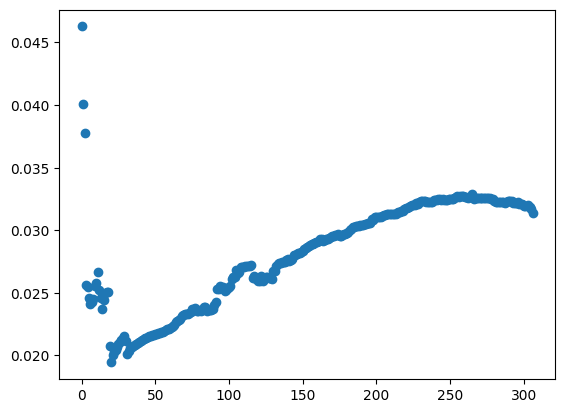

In [17]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

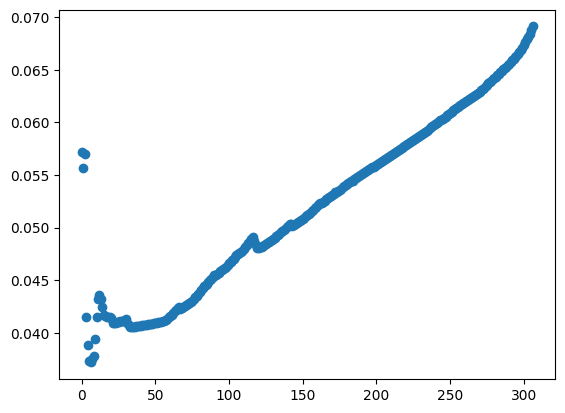

In [18]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [7]:
val_mse_list = [0.05714201631498287,
 0.0556571412352323,
 0.05703356416350354,
 0.04154383218908771,
 0.03885622391773445,
 0.037366640623238974,
 0.03718084218193081,
 0.03748344769481401,
 0.037769937872812846,
 0.03939875639744341,
 0.04148291080762912,
 0.043260669831689115,
 0.043575232392992845,
 0.04326118242685719,
 0.042407875858551,
 0.041709562335708085,
 0.04157966788656315,
 0.04149920756412776,
 0.04149407047398885,
 0.04147040824520381,
 0.04137189853341079,
 0.04094788435176261,
 0.04095990117522049,
 0.04097539614588302,
 0.0410085516661569,
 0.04104893185294549,
 0.041101882514520474,
 0.04113658579367057,
 0.041158285121544506,
 0.041243093861019035,
 0.041273930331973345,
 0.040899372575965154,
 0.04072535591441668,
 0.04053939805897813,
 0.040562392901508294,
 0.04058718792868937,
 0.040594082642128076,
 0.04062599527378833,
 0.04065212634067575,
 0.040664880177446266,
 0.040674952889199964,
 0.04070612932649297,
 0.040739623462724577,
 0.040749393008277526,
 0.04077679619200615,
 0.040799505747652856,
 0.04082895910091573,
 0.040849687573616955,
 0.04087454679408927,
 0.04089548681469935,
 0.04091809180971127,
 0.04093979668411101,
 0.04098180399391631,
 0.04102182305386669,
 0.04106021781695972,
 0.04108239191288717,
 0.04113155813761224,
 0.04122341373563708,
 0.041330810688932615,
 0.04146301384881852,
 0.04160749858659971,
 0.04170441746697885,
 0.04188042121105505,
 0.042054394034084897,
 0.042199535206758114,
 0.042359285103864774,
 0.04245750962194937,
 0.04231000015422026,
 0.04239516991485503,
 0.042413062645582554,
 0.042510660062258114,
 0.042604863486396256,
 0.042731227578257494,
 0.04283859277379275,
 0.04293794759166788,
 0.043056333773130576,
 0.04321949562628098,
 0.04339443303934119,
 0.04352852078891733,
 0.04371173331675203,
 0.04391345852215752,
 0.04410157548076563,
 0.04428949882171203,
 0.0444755182543715,
 0.044561957970740564,
 0.044685065463666226,
 0.04482799434271449,
 0.04500975851552726,
 0.045154863612496696,
 0.04531587575928929,
 0.04546058770032452,
 0.04552794529994057,
 0.04561116674923381,
 0.04568210613157113,
 0.04583709888900321,
 0.04594069828804092,
 0.04605932072604781,
 0.046181255575580955,
 0.046299552702907226,
 0.04645735395251995,
 0.046602903401510944,
 0.04676466896344848,
 0.04688989716605686,
 0.04703857693303684,
 0.0472328993751492,
 0.04738707007422624,
 0.04746357240974877,
 0.047566040831936454,
 0.04768364615431748,
 0.04779904942151698,
 0.04798349613488475,
 0.048163416640932606,
 0.04834042110973345,
 0.048528441817182896,
 0.048734123149466575,
 0.048906487735920885,
 0.049069527080215586,
 0.048696426538513735,
 0.04831491475044472,
 0.04802529334503778,
 0.04802627910590827,
 0.048112394766945274,
 0.048173305048763146,
 0.048246515406717,
 0.04834659660737213,
 0.0484695829491225,
 0.04857555646424071,
 0.04865684795046596,
 0.04873536730291022,
 0.04883255079226702,
 0.048926630311612804,
 0.049031951143371444,
 0.04917006706068432,
 0.049303368608588506,
 0.049397274864615856,
 0.04955068666151757,
 0.049655591675089206,
 0.04977723626647337,
 0.0499065159512489,
 0.05002980931873615,
 0.05019125865820353,
 0.05034304151220849,
 0.050369577137609624,
 0.05018518525797494,
 0.050259862304822975,
 0.050343827301625024,
 0.05041964580938009,
 0.05051728371811774,
 0.050586088014135035,
 0.05072034409929569,
 0.0508445029749651,
 0.05094691724048568,
 0.051056152004190156,
 0.051173476057828494,
 0.051281038174135395,
 0.0514115611644537,
 0.051558651306159844,
 0.05170758311686154,
 0.05184487548980338,
 0.05198719681698496,
 0.052143271811494196,
 0.052283496397089665,
 0.0523450336350453,
 0.05235127215181238,
 0.05246467071928081,
 0.0525580819779747,
 0.052674656697933364,
 0.05277781075863448,
 0.05289626974821217,
 0.05300938045486814,
 0.05311592989513945,
 0.05323068201912614,
 0.05334597590032901,
 0.053398359239346535,
 0.05351550557131969,
 0.0536063093717033,
 0.05371071511830315,
 0.05382430306052991,
 0.05393308690530676,
 0.054034124789595725,
 0.05414623083004426,
 0.05422043567368471,
 0.0543158335215721,
 0.05440250381742877,
 0.05447375053636587,
 0.05458172406182823,
 0.054683709388178826,
 0.054788465034508335,
 0.05490346276242162,
 0.05500199785746553,
 0.0550887533758165,
 0.05519123508320715,
 0.055294098677444746,
 0.055392265573647834,
 0.05549239938244579,
 0.05559945779932488,
 0.055697611963213975,
 0.05578478029361583,
 0.05579889844650571,
 0.05589607361789123,
 0.05599576213280792,
 0.05609039213099594,
 0.056173776922798936,
 0.05626423637721421,
 0.056340996872280134,
 0.05644260786187274,
 0.05652422339659553,
 0.05662138615947628,
 0.056709596368334794,
 0.05680023677401812,
 0.05689033863823902,
 0.056993196178881544,
 0.05709881098253435,
 0.05719887693509421,
 0.05728497910697396,
 0.05738371943407501,
 0.057490861066339924,
 0.05760038392858383,
 0.05769953304561146,
 0.05778392673625873,
 0.057871450915319436,
 0.05797206359829614,
 0.058082955208455286,
 0.05815980026306641,
 0.05823661127720536,
 0.05834530184874002,
 0.058421161304848576,
 0.05850667896298854,
 0.058614947504948355,
 0.05873351750786632,
 0.05882127083120535,
 0.05889175419549973,
 0.0589926337376504,
 0.05908395844700228,
 0.05920214076685558,
 0.059309767640297814,
 0.05942442867504945,
 0.0595385231885225,
 0.059652855582417265,
 0.05977068508083041,
 0.05987067622560677,
 0.059969641616810086,
 0.06008185628221391,
 0.060190817338330614,
 0.060260538877084754,
 0.060337050521646916,
 0.06042541074067278,
 0.06054848773085869,
 0.06066695847933865,
 0.06078367325824589,
 0.06089578421706793,
 0.06100751059611549,
 0.06114367456783777,
 0.061249524824090205,
 0.061369934623112674,
 0.061461546165889266,
 0.06156796188743922,
 0.06164832875026828,
 0.06175768497871466,
 0.06184223970850254,
 0.06193591169257695,
 0.0620514133568145,
 0.06213423739278885,
 0.06225829450931457,
 0.06235325072633595,
 0.062445371882588564,
 0.06249741291662362,
 0.06260484362444003,
 0.06270047665468065,
 0.06280816981378477,
 0.06293246365169178,
 0.06306495216446864,
 0.06320199740427089,
 0.06331639326802652,
 0.06345038166799068,
 0.0635732262551845,
 0.06371215640321588,
 0.06386653876133346,
 0.0639747332764583,
 0.06408506872434554,
 0.06423401952740851,
 0.06435641131675575,
 0.06449049133223707,
 0.06462537972685822,
 0.06475352493723815,
 0.0649082188730195,
 0.06503911170628687,
 0.06517203642454364,
 0.06528781645001604,
 0.06544042531263913,
 0.06559746384353096,
 0.06573228906050674,
 0.06589523254295401,
 0.06603848597400189,
 0.06617474364989305,
 0.0663385679029079,
 0.06650954083397084,
 0.0666698761962021,
 0.06686107161932457,
 0.0670781066860793,
 0.06732519799650474,
 0.06759791495801595,
 0.0678821063295613,
 0.06815627912823681,
 0.06843576221952367,
 0.06874698306903002,
 0.06911693700910618]
min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

6
0.03718084218193081


In [8]:
selected = [106,
 196,
 306,
 30,
 257,
 140,
 112,
 187,
 303,
 14,
 305,
 24,
 178,
 3,
 68,
 32,
 249,
 115,
 176,
 7,
 101,
 54,
 0,
 145,
 1,
 180,
 2,
 4,
 183,
 6,
 275,
 273,
 241,
 48,
 102,
 9,
 11,
 13,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 110,
 250,
 49,
 119,
 19,
 21,
 46,
 28,
 69,
 27,
 217,
 156,
 75,
 216,
 58,
 118,
 130,
 143,
 51,
 50,
 57,
 17,
 153,
 139,
 146,
 92,
 304,
 167,
 91,
 134,
 262,
 98,
 59,
 258,
 271,
 164,
 281,
 38,
 227,
 263,
 259,
 135,
 181,
 126,
 254,
 52,
 148,
 218,
 295,
 190,
 138,
 67,
 299,
 163,
 99,
 240,
 296,
 108,
 124,
 125,
 107,
 233,
 270,
 122,
 219,
 261,
 297,
 268,
 246,
 198,
 123,
 166,
 161,
 96,
 144,
 162,
 66,
 226,
 81,
 87,
 31,
 169,
 76,
 234,
 80,
 103,
 127,
 224,
 298,
 272,
 82,
 22,
 23,
 279,
 237,
 188,
 84,
 221,
 236,
 232,
 244,
 113,
 276,
 170,
 252,
 149,
 255,
 12,
 300,
 277,
 184,
 302,
 278,
 253,
 235,
 93,
 45,
 151,
 301,
 157,
 282,
 79,
 150,
 129,
 286,
 25,
 72,
 173,
 192,
 83,
 242,
 269,
 168,
 160,
 85,
 121,
 182,
 70,
 95,
 104,
 251,
 228,
 109,
 193,
 238,
 77,
 73,
 247,
 89,
 90,
 78,
 117,
 229,
 243,
 274,
 86,
 230,
 220,
 208,
 179,
 291,
 175,
 29,
 292,
 177,
 245,
 239,
 172,
 248,
 158,
 174,
 171,
 147,
 288,
 97,
 141,
 201,
 128,
 294,
 209,
 152,
 195,
 185,
 210,
 199,
 290,
 120,
 203,
 5,
 200,
 186,
 289,
 94,
 223,
 202,
 137,
 88,
 10,
 197,
 44,
 63,
 55,
 131,
 64,
 206,
 260,
 266,
 265,
 116,
 287,
 111,
 215,
 211,
 284,
 212,
 256,
 8,
 293,
 114,
 159,
 165,
 207,
 71,
 225,
 42,
 74,
 213,
 189,
 142,
 205,
 214,
 65,
 280,
 285,
 155,
 100,
 204,
 61,
 231,
 283,
 191,
 34,
 222,
 105,
 264,
 194,
 136,
 154,
 267,
 133,
 132]

#for i in selected[:18]:
    #j = sorted_index[i]
    #print('{}'.format(x_train.columns[j]))

In [9]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

PEOE_VSA8
Atom_LogP_Delta
Iaverage / mA cm-2
Alkylthiol
HOMO-LUMO Gap
VSA_EState10
SMR_VSA4


In [23]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
import os
# 指定图像保存的路径
save_dir = '逐步回归S-体系挑选变量\用师兄的特征 and 汪老师的特征'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
data = x_data[selected_columns]
# 将选定的数据保存为 CSV 文件
output_file = os.path.join(save_dir, "selected_features-n-PrOH.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

PEOE_VSA8  Atom_LogP_Delta  Iaverage / mA cm-2  Alkylthiol  HOMO-LUMO Gap  \
0    4.776499           1.1680          142.333333           0       0.174695   
1    0.000000           0.7226          133.000000           0       0.208260   
2    0.000000           0.9375          134.666667           1       0.250731   
3   11.505707           0.9375          107.333333           0       0.205044   
4   11.505707           0.8517           88.000000           0       0.210880   
..        ...              ...                 ...         ...            ...   
77   0.000000           0.9159           85.333333           2       0.256097   
78   0.000000           0.9159          108.333333           2       0.256083   
79   0.000000           0.9159           83.666667           2       0.255729   
80   0.000000           0.9159           97.666667           2       0.255057   
81   0.000000           0.9159          129.666667           2       0.247211   

    VSA_EState10  SMR_VSA4  
0       1.099537       0.0  
1       4.994213       0.0  
2       3.415895       0.0  
3       0.000000       0.0  
4       1.817130       0.0  
..           ...       ...  
77      8.366555       0.0  
78      8.303644       0.0  
79      8.137006       0.0  
80      8.041327       0.0  
81      7.688272       0.0  

[82 rows x 7 columns]

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
# 用选出来的最佳变量在测试集上进行评估
min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
# 保留两位小数
test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")
# 创建保存目录
import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
output_file1 = os.path.join(save_dir, "final_evaluation-n-PrOH.csv")
# 保存测试集评估结果到CSV
df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['PEOE_VSA8', 'Atom_LogP_Delta', 'Iaverage / mA cm-2', 'Alkylthiol', 'HOMO-LUMO Gap', 'VSA_EState10', 'SMR_VSA4']
Test MSE: 0.055
Test R2: 0.0695
Results saved to 'Test mse after svr/final_evaluation-n-PrOH.csv'
